### _Brazilian Acquirers Financial and Stock Performance vs. Macroeconomic environment_

Analyzing public traded acquirer companies.

We start by comparing their stock and financial performance against macro indexes. Then, we dive into their main financial prospects: multiples comparison, Cash Flow and Income Statement analysis and more.

This is solely a financial data analysis. No stock projection can be prospected from this study. The projection of companies' potential gains or losses take in consideration multiple factors, including: strategic and market analysis, different methods of valuation, and more.

More information on the companies studied here can be found in the links below:
- [STNE](https://investors.stone.co)
- [PAGS](https://investors.pagbank.com)
- [CIEL3](https://ri.cielo.com.br)

### Importings, Functions & Params

In [94]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import numpy_financial as npf
import datetime as dt
from datetime import datetime, timedelta
from plotly import express as px
from matplotlib import (
    dates as mdates,
    ticker,
    pyplot as plt
)
import re
#Data Retrieving
import yfinance as yf
from bcb import sgs 

#ML
from prophet import Prophet

In [95]:
#Functions
def datetime_format(date_str_col, date_format:str=None) -> dt.date:
    """
    Streamlines datetime column conversion for date manipulation. 

    :param date_str_col: pd.DataFrame or pd.Series date string-formated column
    :param date_format: date pattern to change
    """
    try:
        if (date_str_col is not None
            and ~isinstance(date_str_col, str)):
            return pd.to_datetime(date_str_col).dt.strftime(date_format)
        elif isinstance(date_str_col, datetime.timestamp):
            return dt.date(date_str_col)
        else: 
            raise ValueError("Wrong data type. Check your input.")
    except (TypeError, ValueError) as e: 
        raise ValueError(f"An error has ocurred: {e}")
    
def set_fig_context() -> None:
    """
    Streamlines figure context setting.
    """
    plt.style.use('fivethirtyeight')
    sns.set_context('paper')
    sns.set_style('whitegrid')

    plt.tight_layout()
    plt.show()
    return

def format_large_numbers(num: int | float) -> str:
    """
    Format large numbers into more readable formats.

    :param num: input number [int | float]
    """
    try:
        if  7 <= len(str(num)) < 9:
            return '{:.1f}M'.format(num/1e6)
        elif len(str(num)) >= 9 :
            return '{:.1f}B'.format(num/1e9)
        else:
            raise ValueError("Numbers should be at least 7 figures.")
    except (TypeError, ValueError) as e:
        raise ValueError(f"An error has ocurred. Check your input: {e}")

def delta(init_val, final_val):
    delta = ((final_val - init_val)/init_val)*100 
    return delta

def squish(txt):
    return re.sub(r'\s+', '', txt).strip()

In [96]:
#Params
#Tickers
TICKERS = ["STNE", "PAGS", "CIEL3.SA"]

#Dates
START_DATE = datetime.date(datetime.today()) - timedelta(365*5)
BASE_DATE = START_DATE.strftime('%Y-%m-%d')

In [97]:
# Downloding all datasets to be used 

stne, pags, ciel3 = [],[],[] #Stock Price
stne_cf, pags_cf, ciel3_cf = [],[],[] #Cash Flow Statements [Annualized]
stne_financials, pags_financials, ciel3_financials = [],[],[] #Income Statements [Annualized]

for ticker in TICKERS:
    res = yf.download(ticker, start=START_DATE)
    res_ticker = yf.Ticker(ticker)

    if ticker == "STNE":
        stne.append(res)
        stne = pd.concat(stne, axis=0).reset_index()

        stne_financials.append(res_ticker.financials)
        stne_financials = pd.concat(stne_financials, axis=0).reset_index()
        
        stne_cf.append(res_ticker.cash_flow)
        stne_cf = pd.concat(stne_cf, axis=0).reset_index()
        
    elif ticker == "PAGS":
        pags.append(res)
        pags = pd.concat(pags, axis=0).reset_index()

        pags_financials.append(res_ticker.financials)
        pags_financials = pd.concat(pags_financials, axis=0).reset_index()

        pags_cf.append(res_ticker.cash_flow)
        pags_cf = pd.concat(pags_cf, axis=0).reset_index()

    elif ticker == "CIEL3.SA":
        ciel3.append(res)
        ciel3 = pd.concat(ciel3, axis=0).reset_index()

        ciel3_financials.append(res_ticker.financials)
        ciel3_financials = pd.concat(ciel3_financials, axis=0).reset_index()

        ciel3_cf.append(res_ticker.cash_flow)
        ciel3_cf = pd.concat(ciel3_cf, axis=0).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Stock Price and Macro Analysis

In [98]:
stne.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [99]:
sets = {
        'STNE':stne, 
        'PAGS':pags, 
        'CIEL3':ciel3
        }

print("RETURNS OVERVIEW:")
for key, val in sets.items():
	init_date = val['Date'].iloc[0]
	last_date = val['Date'].iloc[-1]
	init_price = val['Close'].iloc[0]
	last_price = val['Close'].iloc[-1]

	print(f"{43*'-'}\n"
		f"Return for *{key}*: {delta(init_price, last_price):.2f}%\n"
		f"Closing price in {init_date}: {init_price:.2f}\n"
		f"Closing price in {last_date}: {last_price:.2f}\n"
		f"{43*'-'}"
)

RETURNS OVERVIEW:
-------------------------------------------
Return for *STNE*: -62.21%
Closing price in 2019-08-13 00:00:00: 34.90
Closing price in 2024-08-09 00:00:00: 13.19
-------------------------------------------
-------------------------------------------
Return for *PAGS*: -73.25%
Closing price in 2019-08-13 00:00:00: 46.80
Closing price in 2024-08-09 00:00:00: 12.52
-------------------------------------------
-------------------------------------------
Return for *CIEL3*: -24.12%
Closing price in 2019-08-13 00:00:00: 7.63
Closing price in 2024-08-09 00:00:00: 5.79
-------------------------------------------


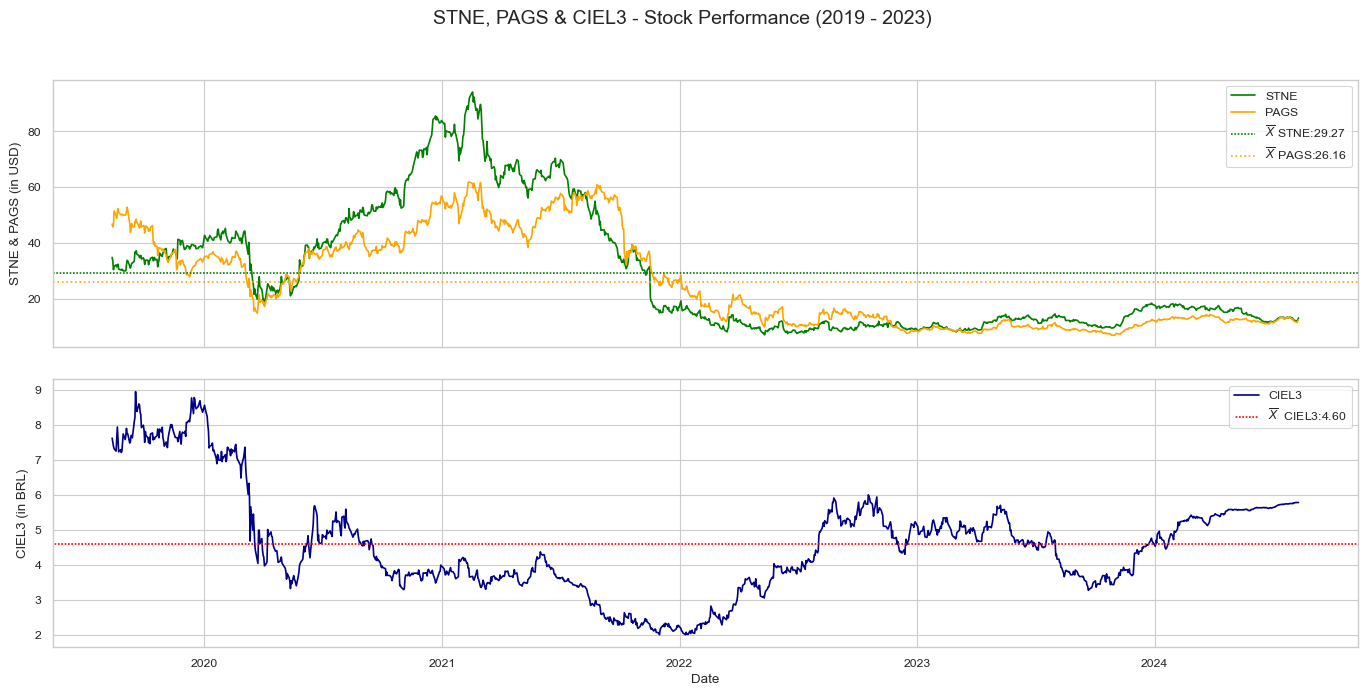

In [100]:
#Overall stocks performance over the past 4 years 
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(15,7), sharex=True)
sns.set_style('whitegrid')

sns.lineplot(data=stne, x='Date', y='Close', color='green', ax=ax, label='STNE')
sns.lineplot(data=pags, x='Date', y='Close', color='orange', ax=ax, label='PAGS')
ax.set_ylabel('STNE & PAGS (in USD)')
ax.axhline(stne['Close'].mean(), color = 'green', linestyle=(0, (1,1)), label='$\overline{X}$ STNE:' + f'{stne["Close"].mean():.2f}')
ax.axhline(pags['Close'].mean(), color = 'orange', linestyle='dotted', label='$\overline{X}$ PAGS:' + f'{pags["Close"].mean():.2f}')

plt.suptitle("STNE, PAGS & CIEL3 - Stock Performance (2019 - 2023)", size=14)

# ax1 = ax.twinx()
sns.lineplot(data=ciel3, x='Date', y='Close', color='darkblue', ax=ax1, label="CIEL3")
ax1.set_ylabel('CIEL3 (in BRL)')
ax1.axhline(ciel3['Close'].mean(), color='r', linestyle=(1, (1,1)), label="$\overline{X}$  CIEL3:" f"{ciel3['Close'].mean():.2f}")

ax.legend(loc='upper right')
ax1.legend(loc='upper right')

plt.subplots_adjust(hspace=0.12)
plt.show()

In [101]:
print("*"*len(str_message))

for stkn in ['stne', 'ciel3', 'pags']:
    global str_message
    
    stk = locals()[stkn]
    str_message = f"Mean close for *{stkn.upper()}* was {stk['Close'].mean().round(2)}"
    print(str_message)

*******************************
Mean close for *STNE* was 29.27
Mean close for *CIEL3* was 4.6
Mean close for *PAGS* was 26.16


In [102]:
# Getting macroeconomic data
macro_data = sgs.get({'selic':432, 'ipca':433}, start=START_DATE)\
                .reset_index()\
                .rename(columns=str.upper)

# macro_data.head()

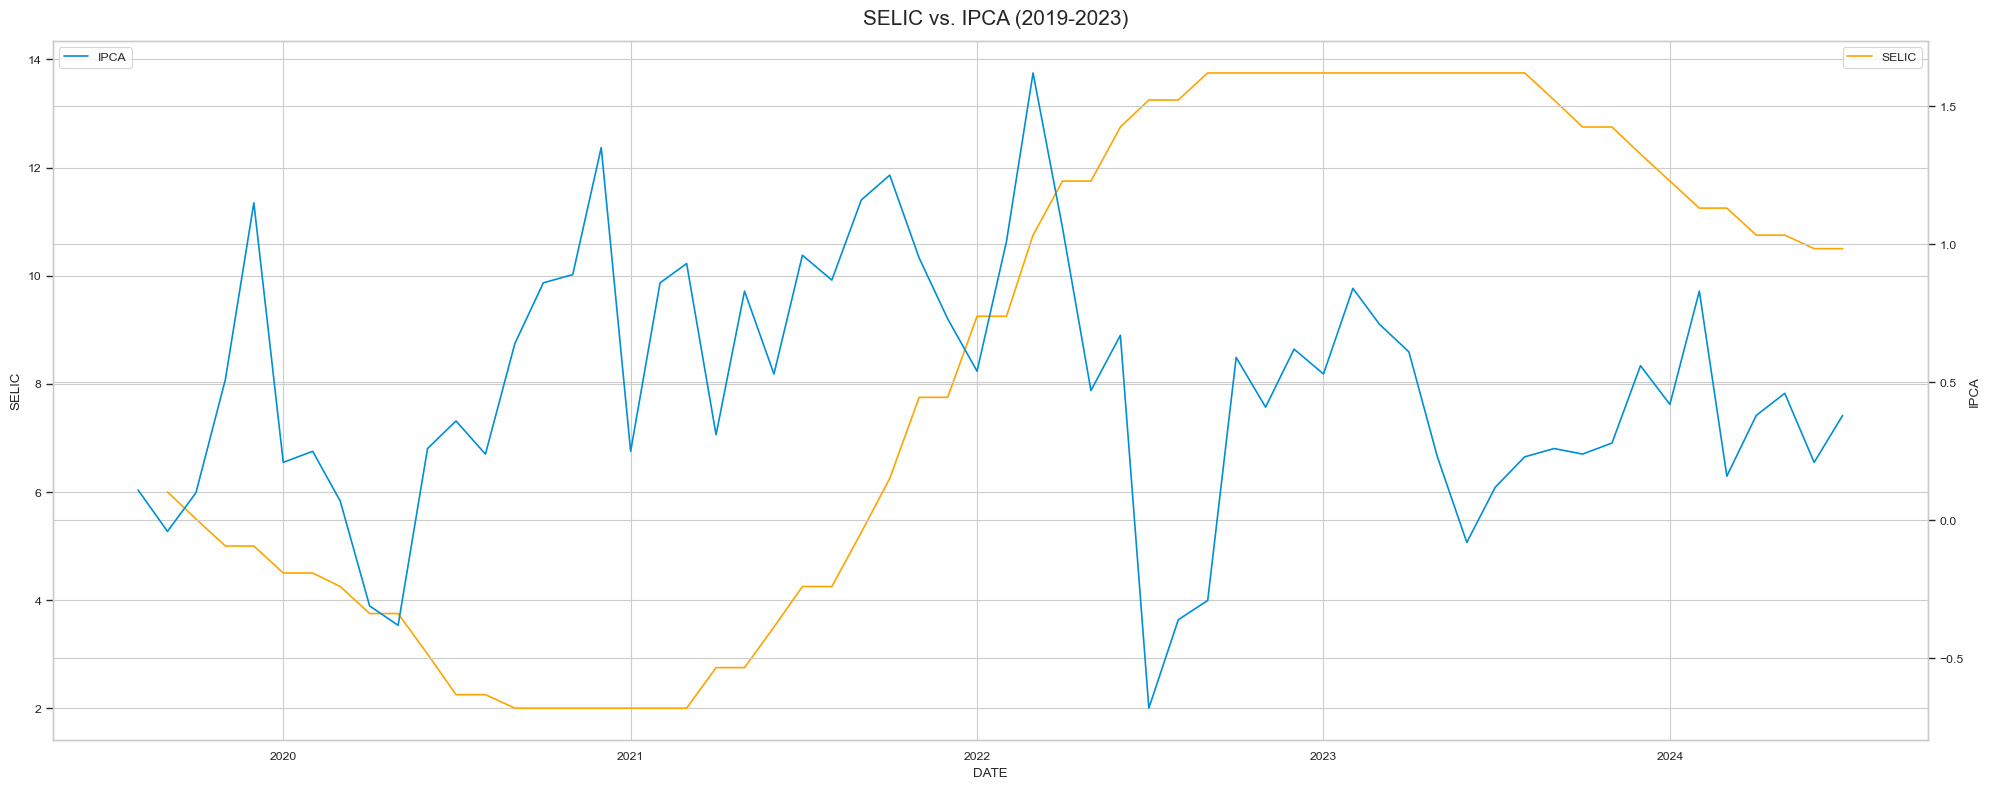

In [103]:
fig, ax = plt.subplots(figsize=(20,8))

ipca = macro_data[['DATE', 'IPCA']].dropna()
selic = macro_data[['DATE', 'SELIC']]

macro = pd.merge(ipca, selic, on='DATE', how='inner')

sns.lineplot(macro, x='DATE', y='SELIC', ax=ax, color='orange', label='SELIC')
ax1 = ax.twinx()
sns.lineplot(macro, x='DATE', y='IPCA', label='IPCA')

plt.suptitle('SELIC vs. IPCA (2019-2023)', size=15)

ax.legend(loc='upper right')
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

### _Performing macro indexes correlation with stock performance_


In [104]:
### Data preparation
%time
#Subsetting major datasets
stne_subset = stne[['Date', 'Close']].copy()
pags_subset = pags[['Date', 'Close']].copy()
ciel3_subset = ciel3[['Date', 'Close']].copy()

#Formatting date
subsets = [stne_subset, pags_subset, ciel3_subset]

for subset in subsets:
    subset['Date'] = datetime_format(subset['Date'], date_format='%Y-%b')

#Stocks unique datasets
stne_pags = pd.merge(stne_subset, pags_subset, on='Date', how='inner')
stne_pags_ciel = pd.merge(stne_pags, ciel3_subset, on='Date', how='inner')\
                    .rename(columns={
                        'Close_x':'Close_STNE',
                        'Close_y':'Close_PAGS',
                        'Close': 'Close_CIEL3'
                                    }).\
                                    sort_values(by='Date')

#Taking the mean value for each month
stne_pags_ciel = stne_pags_ciel.groupby('Date').agg('median').reset_index()
stne_pags_ciel[['Close_STNE', 'Close_PAGS', 'Close_CIEL3']] = stne_pags_ciel[['Close_STNE', 'Close_PAGS', 'Close_CIEL3']]\
                                                                .apply(lambda x: round(x, 2))

stne_pags_ciel.tail()

CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 29.3 µs


,Date,Close_STNE,Close_PAGS,Close_CIEL3
56,2024-Jan,17.33,12.75,4.73
57,2024-Jul,13.21,13.01,5.74
58,2024-Jun,12.14,11.64,5.64
59,2024-Mar,16.70,13.91,5.35
60,2024-May,15.08,12.64,5.59


In [105]:
# Now, macro
macro_data_subset = macro_data.rename(columns=str.capitalize)
macro_data_subset['Date'] = datetime_format(macro_data_subset['Date'], date_format='%Y-%b')

macro_data_subset = macro_data_subset.groupby('Date').agg('median').reset_index()

macro_data_subset.tail()

,Date,Selic,Ipca
56,2024-Jan,11.75,0.42
57,2024-Jul,10.50,0.38
58,2024-Jun,10.50,0.21
59,2024-Mar,11.25,0.16
60,2024-May,10.50,0.46


In [106]:
#Merging both sets together 

stocks_macro_index = pd.merge(stne_pags_ciel, macro_data_subset, on='Date', how='inner')
stocks_macro_index.tail()

,Date,Close_STNE,Close_PAGS,Close_CIEL3,Selic,Ipca
56,2024-Jan,17.33,12.75,4.73,11.75,0.42
57,2024-Jul,13.21,13.01,5.74,10.50,0.38
58,2024-Jun,12.14,11.64,5.64,10.50,0.21
59,2024-Mar,16.70,13.91,5.35,11.25,0.16
60,2024-May,15.08,12.64,5.59,10.50,0.46


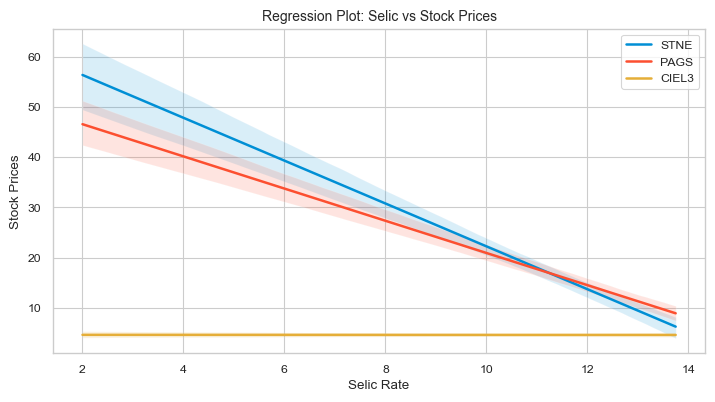

In [107]:
plt.figure(figsize=(7.5, 4))

# Plot regression plots for each stock
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_STNE', label='STNE', scatter=False)
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_PAGS', label='PAGS', scatter=False)
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_CIEL3', label='CIEL3', scatter=False)

plt.title('Regression Plot: Selic vs Stock Prices', size=10)
plt.xlabel('Selic Rate')
plt.ylabel('Stock Prices')

plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Acquirer Stocks Price and Macro Indexes Correlation')

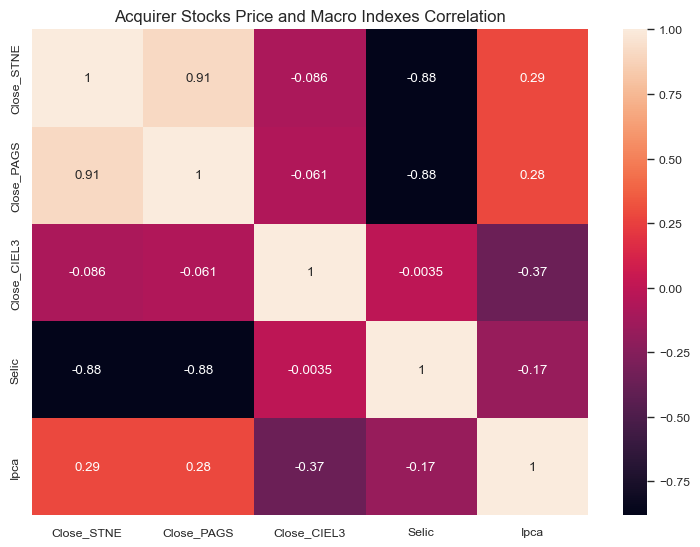

In [108]:
set_fig_context()
fig = plt.subplots(figsize=(8,6))
sns.set_context('paper')

sns.heatmap(stocks_macro_index.corr(method='pearson', numeric_only=True),
            annot=True)
plt.title("Acquirer Stocks Price and Macro Indexes Correlation", size=12)

<Figure size 640x480 with 0 Axes>

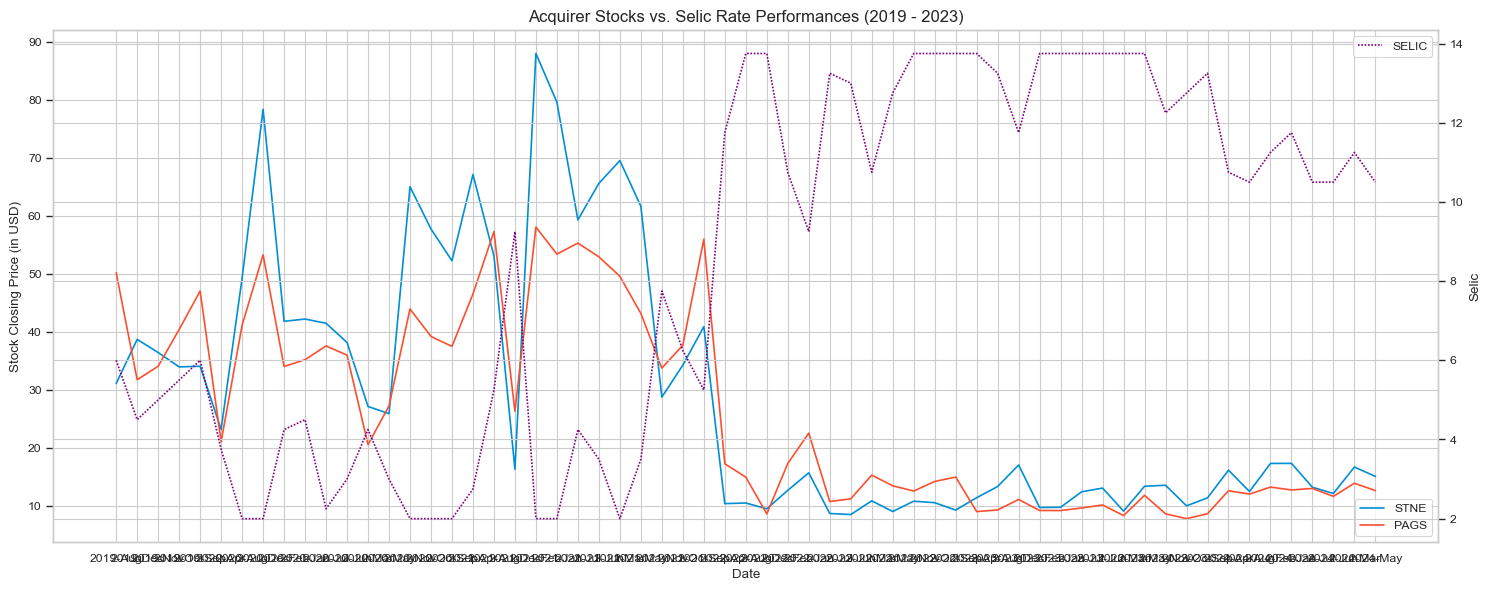

In [109]:
set_fig_context()
fig, ax = plt.subplots(figsize=(15,6))

stocks_only = stocks_macro_index[['Date', 'Close_STNE', 'Close_PAGS', 'Close_CIEL3']]
macro_only = stocks_macro_index[['Date', 'Ipca', 'Selic']]

sns.lineplot(data=stocks_only, x='Date', y='Close_STNE', ax=ax, label='STNE')
sns.lineplot(data=stocks_only, x='Date', y='Close_PAGS', ax=ax, label='PAGS')
ax.set_ylabel('Stock Closing Price (in USD)')
ax1 = ax.twinx()
sns.lineplot(data=macro_only, x='Date', y='Selic', ax=ax1, color='purple', label='SELIC', dashes=(1,1))

ax.legend(loc='lower right')
ax1.legend(loc='upper right')

plt.title("Acquirer Stocks vs. Selic Rate Performances (2019 - 2023)", size=12)

plt.tight_layout()
plt.show()

In [110]:
#Distribution

### Acquirers Financial Performance

- Analyzing revenue growth, cash flow, net debt and liquidity.

For a reminder:

- Revenue: also called top-line

In [111]:
## Dataset formatting and cleaning

financial_cols_rename = {
    '2022-12-31 00:00:00': 'FY2022',
    '2021-12-31 00:00:00': 'FY2021',
    '2020-12-31 00:00:00': 'FY2020'
}

financials_datasets = [stne_financials, pags_financials, ciel3_financials, stne_cf, pags_cf, ciel3_cf]

for i, fs in list(enumerate(financials_datasets)):
    fs.rename(columns=str, inplace=True)
    fs.rename(columns=financial_cols_rename, inplace=True)

### *Forecasting*

In [112]:
ciel3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1243 non-null   datetime64[ns]
 1   Open       1243 non-null   float64       
 2   High       1243 non-null   float64       
 3   Low        1243 non-null   float64       
 4   Close      1243 non-null   float64       
 5   Adj Close  1243 non-null   float64       
 6   Volume     1243 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.1 KB


In [113]:
m = Prophet()

In [114]:
ciel3_slice = ciel3[['Date', 'Close']]

ciel3_slice.head()

,Date,Close
0,2019-08-13,7.63
1,2019-08-14,7.51
2,2019-08-15,7.40
3,2019-08-16,7.33
4,2019-08-19,7.26


In [115]:
ciel3_slice = ciel3_slice.rename(columns={'Date': 'ds', 'Close': 'y'})

ciel3_slice.head()

,ds,y
0,2019-08-13,7.63
1,2019-08-14,7.51
2,2019-08-15,7.40
3,2019-08-16,7.33
4,2019-08-19,7.26


In [116]:
m.fit(ciel3_slice)

09:29:46 - cmdstanpy - INFO - Chain [1] start processing
09:29:47 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
future = m.make_future_dataframe(freq='D', periods=181)

forecast = m.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-13,7.855107,7.640806,8.658888,7.855107,7.855107,0.298748,0.298748,0.298748,0.070405,0.070405,0.070405,0.228343,0.228343,0.228343,0.0,0.0,0.0,8.153855
1,2019-08-14,7.856993,7.642624,8.703113,7.856993,7.856993,0.280435,0.280435,0.280435,0.069587,0.069587,0.069587,0.210849,0.210849,0.210849,0.0,0.0,0.0,8.137428
2,2019-08-15,7.858879,7.622306,8.635782,7.858879,7.858879,0.274456,0.274456,0.274456,0.080905,0.080905,0.080905,0.193550,0.193550,0.193550,0.0,0.0,0.0,8.133335
3,2019-08-16,7.860766,7.602387,8.598002,7.860766,7.860766,0.258924,0.258924,0.258924,0.082286,0.082286,0.082286,0.176638,0.176638,0.176638,0.0,0.0,0.0,8.119690
4,2019-08-19,7.866425,7.579117,8.531189,7.866425,7.866425,0.207158,0.207158,0.207158,0.077360,0.077360,0.077360,0.129798,0.129798,0.129798,0.0,0.0,0.0,8.073582


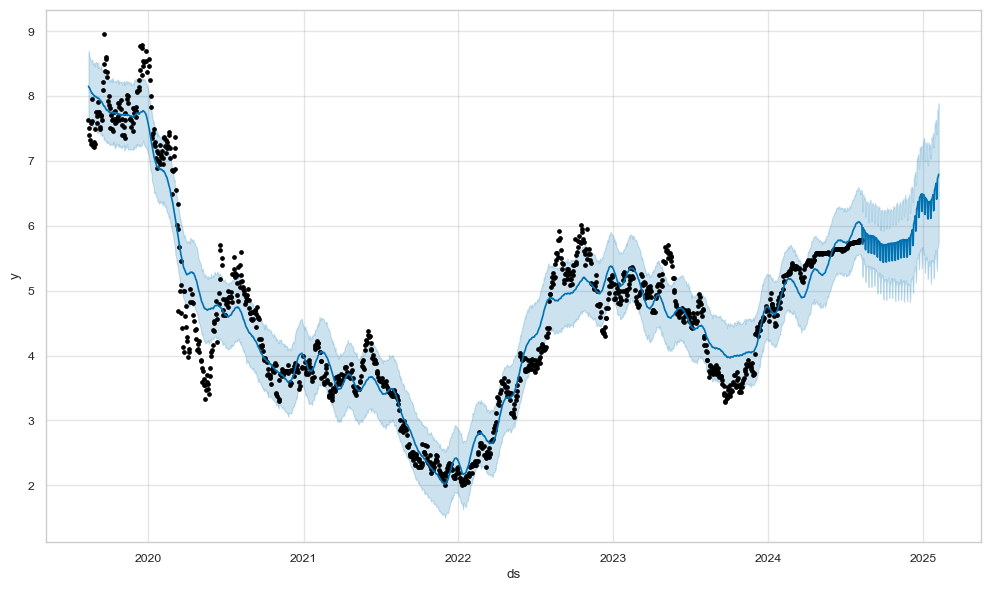

In [118]:
m.plot(forecast)
plt.show()